# Scientific Computing Project :  Human activity detection - DTW and classification with preprocessing


**First Name:**

**Last name:**


In this project, we will try to predict human activity (1-Downstairs, 2-Jogging, 3-Sitting, 4-Standing, 5-Upstairs or 6-Walking) using smartphone sensors. That is, by using the following methods, the smartphone can detect what we are doing right now.

Using the accelerometer integrated in the smartphone, the 3-axis linear acceleration at a constant rate of 50Hz was measured. The experiments were recorded on video to label the data manually. 

<img src="files/HARDataset.JPG" width="800" height="600"  >

It is provided for each record in the dataset : 
- The triaxial acceleration of the accelerometer (total acceleration) and the estimated acceleration of the body. 
- Its activity label. 
- An identifier of the subject who performed the experiment.

These 4 sessions are divided into 4 parts: 
- Part I: DTW and application of the TD
- Part II: Physical Activity Recognition System with DTW
- Part III: Comparison of dynamic programming with a classification method after pre-processing of data by PCA
- Part IV: Your Study

**Work to be returned**

To do so, you must be in pairs (number **OBLIGATORY**):
1. Implement the DTW, test the TD exercises;
3. Use the DTW to create a recognition system;
4. Evaluate the results using the confusion matrix and the percentage of good classification;
5. Implement PCA and kppv. 
6. Write a pdf report presenting your study: the results by the 2 methods and your comments and conclusions on a more general study by modifying the sizes of the test and learning sets, changing the number of classes (max. length: 10 pages).

**Dataset and description :**
https://archive.ics.uci.edu/ml/datasets/WISDM+Smartphone+et+Smartwatch+Activité+et+Biométrie+Dataset


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import pandas as pd
import math
from scipy import stats
import seaborn as sns

In [2]:
# Dataset parameters
COLUMN_NAMES = [
    'user',
    'activity',
    'timestamp',
    'x-axis',
    'y-axis',
    'z-axis'
]

LABELS = [
    'Downstairs',
    'Jogging',
    'Sitting',
    'Standing',
    'Upstairs',
    'Walking'
]

DATA_PATH = './WISDM_ar_v1.1_raw.txt'


TIME_STEP = 60

# Parameter
N_CLASSES = 3
N_FEATURES = 3  # x-acceleration, y-acceleration, z-acceleration
SEGMENT_TIME_SIZE = 30 #length of time series
TAILLE_TEST=30 #
TAILLE_APP=10

## 1. Loading of both learning and test data

Convoluted data shape:  (8376, 30, 3)
Labels shape: (8376,)
Classe N° 0
Classe N° 1
Classe N° 2


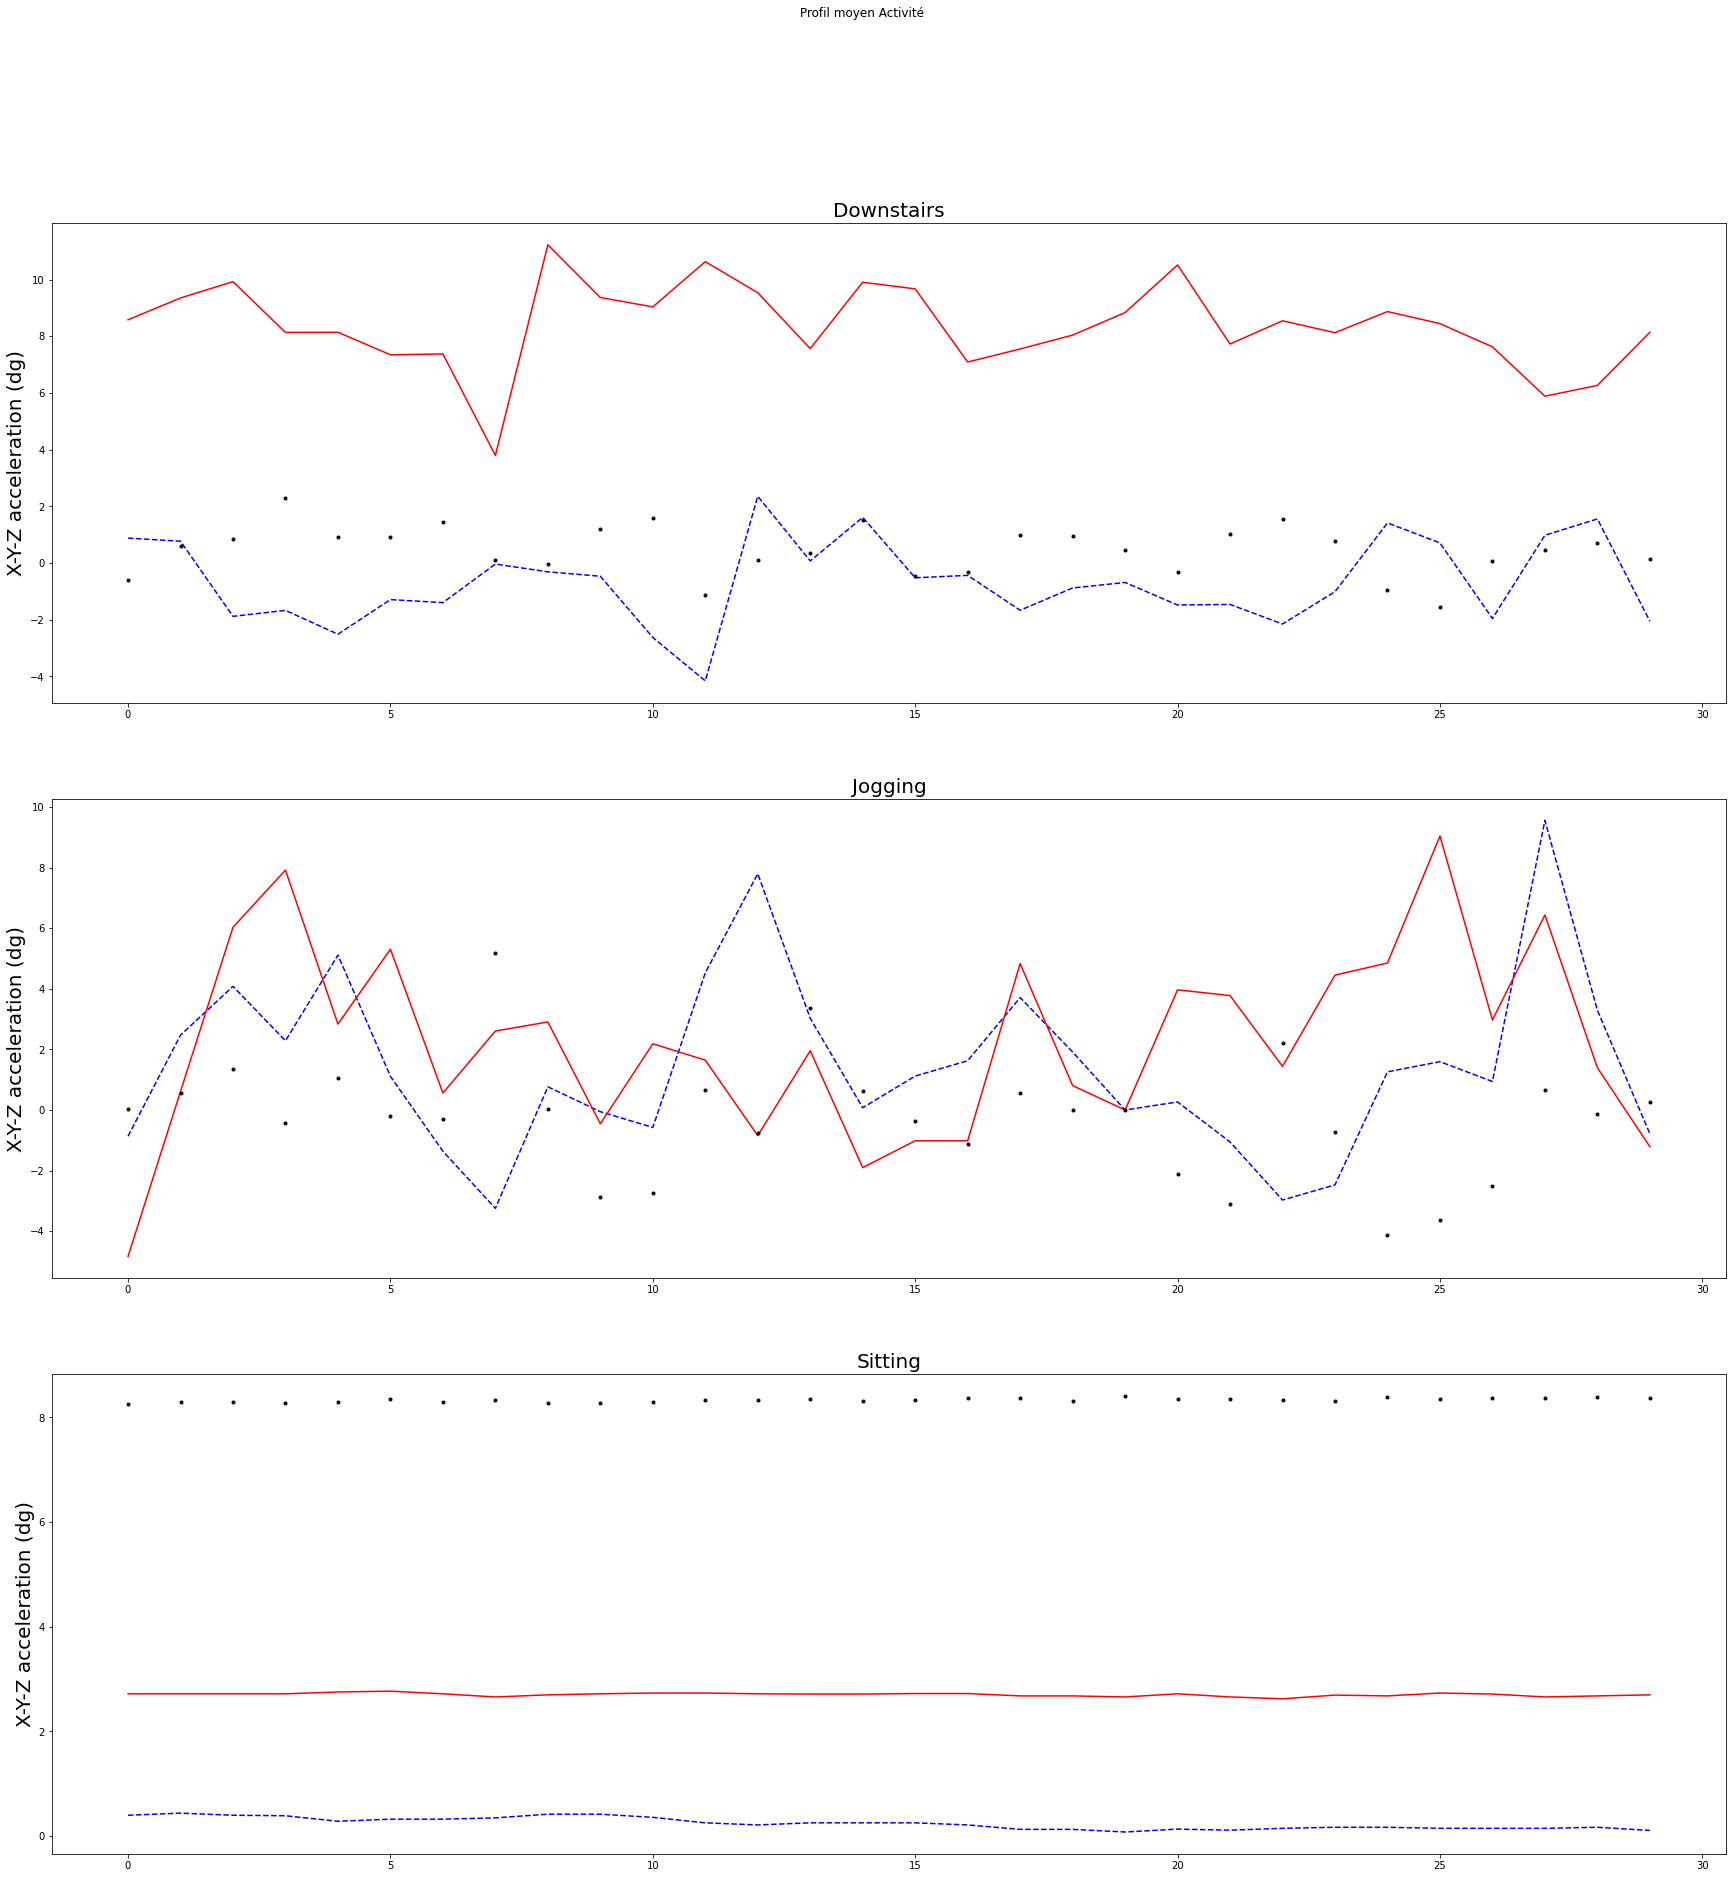

In [3]:
# Download data
data = pd.read_csv(DATA_PATH, header=None, names=COLUMN_NAMES)
data['z-axis'].replace({';': ''}, regex=True, inplace=True)
data = data.dropna()

# DATA PREPROCESSING
data_convoluted = []
labels = []



# Take time segments of size SEGMENT_TIME_SIZE 
# all TIME_STEPs for the same activity
for j in range(0,N_CLASSES):
    DataBest=data[data['activity'] == LABELS[j]]
    for i in range(0, len(DataBest) - SEGMENT_TIME_SIZE, TIME_STEP):
        x = DataBest['x-axis'].values[i: i + SEGMENT_TIME_SIZE]
        y = DataBest['y-axis'].values[i: i + SEGMENT_TIME_SIZE]
        z = DataBest['z-axis'].values[i: i + SEGMENT_TIME_SIZE]
        data_convoluted.append([x, y, z])
    # Label of the activity associated with each segment
        label = j
        labels.append(label)


# Numpy conversion
data_convoluted = np.asarray(data_convoluted, dtype=np.float32).transpose(0, 2, 1)
labels = np.asarray(labels, dtype=np.int)
print("Convoluted data shape: ", data_convoluted.shape)
print("Labels shape:", labels.shape)



fig, axs = plt.subplots(N_CLASSES,figsize=(30,30))
fig.suptitle('Profil moyen Activité')

profil_moyen=np.zeros((N_CLASSES,SEGMENT_TIME_SIZE,N_FEATURES))
List_Data_Test=np.zeros(N_CLASSES*TAILLE_TEST)
Data_Test=np.zeros((N_CLASSES*TAILLE_TEST,SEGMENT_TIME_SIZE*N_FEATURES))
Data_App=np.zeros((TAILLE_APP*N_CLASSES,SEGMENT_TIME_SIZE*N_FEATURES))
Label_Test=np.zeros(N_CLASSES*TAILLE_TEST)
Label_App=np.zeros(N_CLASSES*TAILLE_APP)

for i in range(N_CLASSES):
    # Selection of data corresponding to class activity i
    print('Classe N°',i)
    res=np.where(labels==i)
    res=np.array(res)
    res=np.ravel(res)
    taille=res.shape[0]
    
    # Creation of the Test base by random selection on time profiles

    tirage=np.random.randint(0,taille,TAILLE_TEST)
    List_Data_Test[i*TAILLE_TEST:(i+1)*TAILLE_TEST]=res[tirage[0:TAILLE_TEST]]
    Label_Test[i*TAILLE_TEST:(i+1)*TAILLE_TEST]=i
    tir_dataTest=data_convoluted[res[tirage[0:TAILLE_TEST]],:,:]
    Data_Test[i*TAILLE_TEST:(i+1)*TAILLE_TEST,:]=np.reshape(tir_dataTest,(TAILLE_TEST,SEGMENT_TIME_SIZE*N_FEATURES))
    
    
    # Creation of the Learning base by random selection on time profiles
    tirage1=np.random.randint(0,taille,TAILLE_APP)
    tir_dataApp=data_convoluted[res[tirage1[0:TAILLE_APP]],:,:]
    Data_App[i*TAILLE_APP:(i+1)*TAILLE_APP,:]=np.reshape(tir_dataApp,(TAILLE_APP,SEGMENT_TIME_SIZE*N_FEATURES))
    Label_App[i*TAILLE_APP:(i+1)*TAILLE_APP]=i
    
    # Displaying the median time profile of the class 
    class1=np.median(tir_dataApp,axis=0)
    profil_moyen[i,:,:]=class1
    axs[i].plot(range(SEGMENT_TIME_SIZE),class1[:,0],'b--')
    axs[i].plot(range(SEGMENT_TIME_SIZE),class1[:,1],'r-')
    axs[i].plot(range(SEGMENT_TIME_SIZE),class1[:,2],'k.')
    axs[i].set_ylabel('X-Y-Z acceleration (dg)',fontsize=20)
    axs[i].set_title(LABELS[i], fontsize=20)




# Part I: Implementation of the Dynamic Programming Algorithm 

1. Write a DTW python function that implements the calculation and display of the cost matrix defined in TD. 

2. In order to easily adapt the calculation of the costs according to the nature of the data (and thus the distances used), write a function for each distance (Euclidean, letters, sounds) which will appear as a parameter of the DTW function.

In [4]:
from math import *
import numpy as np
import sys

w1=1
w2=1
w3=1

def DTW(A, B, window = sys.maxsize, d = lambda x,y: np.linalg.norm((x-y))):
    # create the cost matrix
    A= np.array(A)
    B= np.array(B)
    M= len(A)
    N= len(B)
    cost = np.ones((M, N))

    # initialize the first row and column
    cost[0, 0] = d(A[0], B[0])
    for i in range(1, M):
        cost[i, 0] = cost[i-1, 0] + d(A[i], B[0])

    for j in range(1, N):
        cost[0, j] = cost[0, j-1] + d(A[0], B[j])
    # fill in the rest of the matrix
    for i in range(1, M):
        for j in range(max(1, i - window), min(N, i + window)):
            choices = w2*cost[i - 1, j - 1], w1*cost[i, j-1], w3*cost[i-1, j]
            cost[i, j] = min(choices) + d(A[i], B[j])

    # find the optimal path
    n, m = N - 1, M - 1
    path = []

    while (m, n) != (0, 0):
        path.append((m, n))
        m, n = min((m - 1, n), (m, n - 1), (m - 1, n - 1), key = lambda x: cost[x[0], x[1]])
    
    path.append((0,0))
    return cost[-1, -1]/(N+M), path



### Application to exercises 

 Test your programs on the exercises seen in TD.

# Part II: Physical Activity Recognition System with DTW



For each test time profile,
- Calculate for each class, the DTW score between the test time profile and the class time profiles 
- Determine the class to which you belong by minimum score on all classes

In [5]:
# Recognition system from the DTW
PartitionDTW=np.zeros((TAILLE_TEST*N_CLASSES,2))

for num in range(TAILLE_TEST*N_CLASSES):
    #print('Donnee N°',num)
    result=np.zeros(N_CLASSES)
    for i in range(N_CLASSES):
        val=int(List_Data_Test[num])
        # To be generalized for other activity profiles of the learning base
        #(not only the average/median profile)
        cost,path =DTW(data_convoluted[val,:,:],profil_moyen[i,:,:])
        result[i]=cost
        index=np.argmin(result)
        PartitionDTW[num,0]=index
        PartitionDTW[num,1]=Label_Test[num]
        

## Evaluation of the results of the DTW

From the partition of the test set obtained after the DTW, calculate the confusion matrix that identifies the number of well-ranked and misranked data.

Confusion matrix by DTW
Performance in % on a test basis:
Accuracy sur base de test : 0.7


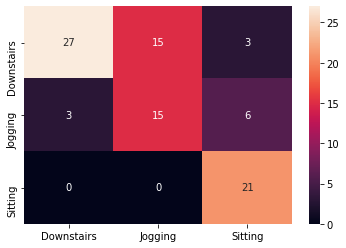

In [6]:
# Evaluation of results by confusion matrices 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

print('Confusion matrix by DTW')
cm=confusion_matrix(PartitionDTW[:,0],PartitionDTW[:,1])
sns.heatmap(data=cm,fmt='.0f',xticklabels=np.unique(LABELS[:N_CLASSES]),yticklabels=np.unique(LABELS[:N_CLASSES]),annot=True)


# performance score
print('Performance in % on a test basis:')
print('Accuracy sur base de test :',accuracy_score(PartitionDTW[:,0],PartitionDTW[:,1]))

# Part III: Comparison of dynamic programming with a classification method after data pre-processing

In this part, we will compare the results of the DTW with those of a data classification method: the k-nearest neighbors.

We will use the functions to compute PCA and kppv via the python library *scikit-learn*.

In [7]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from mpl_toolkits.mplot3d import Axes3D

### Pre-processing by ACP

To test another classification method, 

1. From the Data_App data of the learning database and using the *PCA* function of the *scikit-learn* library, calculate the 3 main axes of the PCA by
extracting the 3 eigenvectors, noted $X_1$, $X_2$, $X_3$, associated with the 3 largest eigenvalues of the matrix of
variance-covariance $\Sigma_{App}$.These eigenvectors will constitute the new database.

2. Project the data from the learning and test database into this new database by multiplying each
vector by the base $P = [X_1X_2X_3]$.

*Note:* You can also implement PCA in
extracting the 3 eigenvectors, noted $X_1$, $X_2$, $X_3$, associated with the 3 largest eigenvalues of the matrix of
variance-covariance $\Sigma_{App}$ (by the functions *np.cov* and *np.linalg.eig*). These eigenvectors will be the new marker P. Then project the data from the training and test database into this new database by multiplying each vector by the database $P = [X_1X_2X_3]$.


In [8]:
from sklearn.decomposition import PCA

n_components=3
pca = PCA(n_components)
principalComponentsApp = pca.fit_transform(Data_App)
principalComponentsTest= pca.transform(Data_Test)

# Contrast information based on variance ratio (eigenvalues ratio)
print(sum(pca.explained_variance_ratio_))

0.5687042462655489


### Classification by k nearest neighbors

In artificial intelligence, the k-nearest neighbor (k-nn) method is a learning method
supervised. Within this framework, a learning database is available consisting of "data-label" pairs. To estimate the output associated with a new input x, the closest k neighbor method consists in taking
(identically) the k learning samples whose input is closest to the new learning sample.
input x, according to a distance to be defined. The associated algorithm and an example (figure 1) are given below.

<img src="files/knn.jpg" width="500" height="400"  >

<img src="files/kppv.png" width="300" height="300"  >

**Example of classification by k-nn.**

 The test specimen (green circle) must be classified either in the first
class of blue squares, or in the second class of red triangles. 
If k = 3 (full circle), it is assigned to the second class because there are 2 triangles and only 1 square inside the inner circle. 
If k = 5 (dotted circle), it is assigned to the first class (3 squares versus 2 triangles inside the outer circle).

1. Using the *KNeighborsClassifier* function from the *sklearn.neighbors* library, perform a k-ppv classification based on the learning and test base you have predefined (take $k=1$).

2. Evaluate the k-ppv method by calculating the confusion matrix and the recognition rate.

3. Change the value of $k$ for k-ppv. Do you improve recognition scores?

4. Compare your results with those of the DTW.

In [9]:
# Apply knn on principal components
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(principalComponentsApp, Label_App)
pred_i = knn.predict(principalComponentsTest)

# Evaluation of results by confusion matrices 
print('Confusion matrix with ACP+kNN')

# performance score
print('Performance in % on a test basis:')

Confusion matrix with ACP+kNN
Performance in % on a test basis:


# Part IV: Your Study

Make your own study in :
- Increasing the test and/or learning bases and/or the length of the segments 
- by proposing variants (change of standard for DTW, different weighting for wi, local constraint, test with more eigenvectors for PCA (use contrast)...)
- by adding more classes (up to 3 more classes: 4-Standing, 5-Upstairs or 6-Walking ) 
all while testing both approaches and interpreting the results, to be synthesized in a report. 